# Verkehrsmittelwahl

### Dataset

https://www.data.gv.at/katalog/dataset/3e9af1f2-9333-4c1c-978f-9a0c6771fce3#additional-info

- Bezirklevel
- 2002-2023

= Registered Vehicled / per 1000 inhabitants:
- CAR
- LKW

## Prepare Data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Load the raw CSV, skipping the first descriptive row so the second row becomes the header
raw_path = "../data_arima_raw/fahrzeuge.csv"
df_raw = pd.read_csv(raw_path, sep=";", header=1)

# Keep only the columns we need: year, district code, and densities
df = df_raw[["REF_YEAR", "DISTRICT_CODE", "PKW_DENSITY", "LKW_DENSITY"]].copy()

# Normalize the density strings: remove thousands separators “.”, replace decimal comma with dot, then convert to float
for col in ["PKW_DENSITY", "LKW_DENSITY"]:
    df[col] = (
        df[col]
        .str.replace(r"\.", "", regex=True)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

# Convert 5-digit DISTRICT_CODE (e.g. 90100) into a Viennese postal code (e.g. 1010)
def code_to_plz(code):
    dnum = (int(code) % 10000) // 100
    return int(f"1{dnum:02d}0")

df["BEZIRK"] = df["DISTRICT_CODE"].apply(code_to_plz)

# Create a proper datetime column for the start of each reference year
df["DATE"] = pd.to_datetime(df["REF_YEAR"].astype(str) + "-01-01")
df = df[["DATE", "BEZIRK", "PKW_DENSITY", "LKW_DENSITY"]]

## Forecast

In [4]:
# List to collect each district’s monthly forecast
monthly_list = []

# Loop over each district to forecast separately
for bezirk, group in df.groupby("BEZIRK"):
    # Build an annual series (2002–2023) for this district
    group_ann = group.set_index("DATE").sort_index().asfreq("YS")
    
    # Create a full annual index from 2002 through 2030 and fill observed values
    annual_idx = pd.date_range("2002-01-01", "2030-01-01", freq="YS")
    full_ann = pd.DataFrame(index=annual_idx, columns=["PKW_DENSITY", "LKW_DENSITY"], dtype=float)
    full_ann.loc[group_ann.index, ["PKW_DENSITY", "LKW_DENSITY"]] = group_ann[["PKW_DENSITY", "LKW_DENSITY"]].values
    
    # Forecast 2024–2030 for each density series using ARIMA(1,1,1)
    n_fore = 7  # number of years to forecast (2024–2030)
    for col in ["PKW_DENSITY", "LKW_DENSITY"]:
        series = group_ann[col].dropna()
        model = ARIMA(series, order=(1, 1, 1))
        fitted = model.fit()
        future_idx = pd.date_range("2024-01-01", periods=n_fore, freq="YS")
        full_ann.loc[future_idx, col] = fitted.forecast(steps=n_fore).values
    
    # Upsample the annual data to month-end frequency and forward-fill
    monthly = full_ann.astype(float).resample("ME").ffill()
    
    # Ensure every month between Jan 2002 and Dec 2030 is present
    all_month_ends = pd.date_range("2002-01-31", "2030-12-31", freq="ME")
    monthly = monthly.reindex(all_month_ends).ffill()
    
    # Convert the index to the first of each month
    monthly.index = monthly.index.to_period("M").to_timestamp()
    
    # Replace any negative forecasts with zero
    monthly = monthly.clip(lower=0)
    
    # Add the district identifier and reset index so DATE is a column
    monthly["BEZIRK"] = bezirk
    monthly = monthly.reset_index().rename(columns={"index": "DATE"})
    
    # Keep only the columns we want in the final output
    monthly = monthly[["DATE", "BEZIRK", "PKW_DENSITY", "LKW_DENSITY"]]
    monthly_list.append(monthly)

c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

## Final Adjustments

In [5]:
# Combine all districts into a single long-form DataFrame
veh_monthly_long = pd.concat(monthly_list, ignore_index=True)

In [6]:
# Save to CSV for later merging with traffic-counter data
output_path = "../data_arima_final/vehicle_density.csv"
veh_monthly_long.to_csv(output_path, index=False)

#### Plot

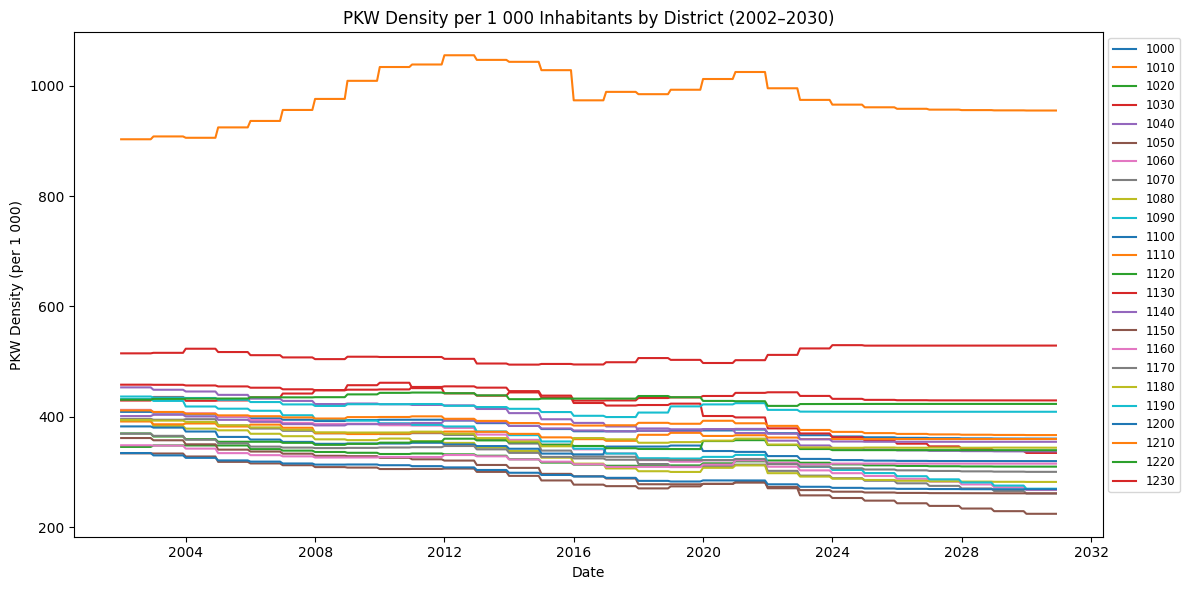

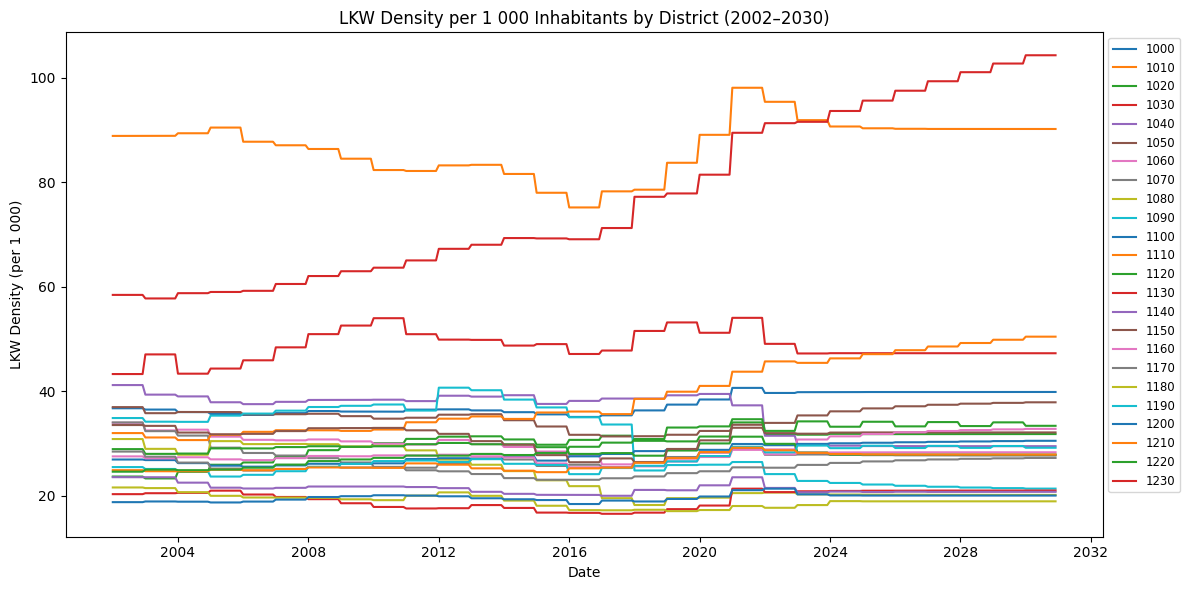

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot to wide form for PKW and LKW separately (index = DATE, columns = BEZIRK)
pkw_wide = veh_monthly_long.pivot(index="DATE", columns="BEZIRK", values="PKW_DENSITY")
lkw_wide = veh_monthly_long.pivot(index="DATE", columns="BEZIRK", values="LKW_DENSITY")

# Plot PKW density: one line per district
plt.figure(figsize=(12, 6))
for bezirk in pkw_wide.columns:
    plt.plot(pkw_wide.index, pkw_wide[bezirk], label=str(bezirk))
plt.title("PKW Density per 1 000 Inhabitants by District (2002–2030)")
plt.xlabel("Date")
plt.ylabel("PKW Density (per 1 000)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()

# Plot LKW density: one line per district
plt.figure(figsize=(12, 6))
for bezirk in lkw_wide.columns:
    plt.plot(lkw_wide.index, lkw_wide[bezirk], label=str(bezirk))
plt.title("LKW Density per 1 000 Inhabitants by District (2002–2030)")
plt.xlabel("Date")
plt.ylabel("LKW Density (per 1 000)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()
